In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from utils import data_path, get_rmse, plot_diff

# Load data

In [2]:
simus = ['ssp126',
         'ssp370',
         'ssp585']

In [3]:
len_historical = 165

In [4]:
X_train = []
Y_train = []

for i, simu in enumerate(simus):

    input_name = 'inputs_' + simu + '.nc'
    output_name = 'outputs_' + simu + '.nc'

    # load inputs 
    input_xr = xr.open_mfdataset([data_path + 'inputs_historical.nc', 
                                data_path + input_name]).compute()
        
    # load outputs                                                             
    output_xr = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').mean(dim='member'),
                            xr.open_dataset(data_path + output_name).mean(dim='member')],
                            dim='time').compute()
    output_xr = output_xr.assign({"pr": output_xr.pr * 86400,
                                    "pr90": output_xr.pr90 * 86400}).rename({'lon':'longitude', 
                                                                            'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])

    print(input_xr.dims, simu)

    # Append to list 
    X_train.append(input_xr)
    Y_train.append(output_xr)

/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_60303/2291542157.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_60303/2291542157.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])


FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585


/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_60303/2291542157.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])


# Data normalization

In [5]:
# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[0][var].data
    std = meanstd_dict[1][var].data
    return (data - mean)/std

def unnormalize(data, var, meanstd_dict):
    mean = meanstd_dict[0][var].data
    std = meanstd_dict[1][var].data
    return data * std + mean

In [6]:
meanstd_inputs = X_train[-1].mean(), X_train[-1].std()

In [7]:
# normalize input data 
X_train_norm = [] 
for i, train_xr in enumerate(X_train): 
    for var in ['CO2', 'CH4', 'SO2', 'BC']: 
        var_dims = train_xr[var].dims
        train_xr=train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs))}) 
    X_train_norm.append(train_xr)

## Reshape data to feed into the model 

In [8]:
slider = 10 # years moving temporal window 

In [9]:
def sliding_window_X(X_train_np, len_historical=None):
    time_length = X_train_np.shape[0]
    
    Y_train_to_return = np.array([X_train_np[i:i+slider] for i in range(len_historical-slider+1, time_length-slider+1)])
    
    return Y_train_to_return

def sliding_window_Y(Y_train_np, len_historical=None):
    time_length = Y_train_np.shape[0]
    
    Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(len_historical-slider+1, time_length-slider+1)])
    
    return Y_train_to_return

# CNN - LSTM architecture
## Build model

In [10]:
var_to_predict =  'tas'
X_train_all = np.concatenate([sliding_window_X(_train.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical) for _train in X_train_norm], axis = 0)
Y_train_all = np.concatenate([sliding_window_Y(_train['tas'], len_historical=len_historical) for _train in Y_train], axis=0)
print(X_train_all.shape)
print(Y_train_all.shape)

(258, 10, 96, 144, 4)
(258, 1, 96, 144)


Inspiration: https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

import random 
seed = 42 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [12]:
keras.backend.clear_session()
cnn_model = None

In [13]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='tanh'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))


/Users/nightfury/UCSD/SPRING 2024/SIOC 209/sioc209-2024-sp/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 96, 144,    │           740 │
│ (TimeDistributed)               │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 48, 72, 20) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 20)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25)             │         4,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13824)          │       359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 96, 144)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,764 (1.39 MB)

 Trainable params: 364,764 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mse']) 

# Train model

In [16]:
X_train_all.shape, Y_train_all.shape

((258, 10, 96, 144, 4), (258, 1, 96, 144))

In [17]:
hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     #use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=30,
                     verbose=1)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - loss: 7.9200 - mse: 7.9200
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - loss: 7.0786 - mse: 7.0786
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 5.4867 - mse: 5.4867
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - loss: 4.0771 - mse: 4.0771
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - loss: 3.2158 - mse: 3.2158
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 2.7253 - mse: 2.7253
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - loss: 2.4100 - mse: 2.4100
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - loss: 2.1895 - mse: 2.1895
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - loss: 2.0271 - mse: 2.0271
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - loss: 1.8996 - mse: 1.8996
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 1.7873 - mse: 1.7873
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 1.6689 - mse: 1.6689
Epoch 13/30
17/17 ━━━━━━━

# Make final prediction for submission

In [18]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = sliding_window_X(X_test.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical)  

In [19]:
# Make predictions using trained model 
m_pred = cnn_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], 
                      coords=[X_test.time.data[len_historical:], 
                              X_test.latitude.data, 
                              X_test.longitude.data]).sel(time=slice(2015, 2101))
m_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


<xarray.DataArray (time: 86, lat: 96, lon: 144)> Size: 5MB
array([[[1.1702788, 1.1696845, 1.1673188, ..., 1.1796187, 1.1724546,
         1.180596 ],
        [1.2306303, 1.2228556, 1.2327124, ..., 1.2261392, 1.2142617,
         1.2152833],
        [1.2217801, 1.2135276, 1.2204988, ..., 1.1949599, 1.202288 ,
         1.2006981],
        ...,
        [2.916055 , 2.8776217, 2.8905694, ..., 2.9377966, 2.9089851,
         2.9402606],
        [2.980583 , 2.962496 , 2.961558 , ..., 3.0157914, 2.979377 ,
         2.9718223],
        [3.0400305, 3.0594919, 3.059986 , ..., 3.053788 , 3.0454965,
         3.0601919]],

       [[1.1857475, 1.1852959, 1.1829834, ..., 1.1959041, 1.1883936,
         1.1962538],
        [1.2473127, 1.2398415, 1.2494426, ..., 1.242755 , 1.2310314,
         1.2317331],
        [1.2381849, 1.229757 , 1.2370484, ..., 1.2107687, 1.2183821,
         1.2168187],
...
        [6.54862  , 6.529606 , 6.488402 , ..., 6.5378027, 6.564042 ,
         6.5538316],
        [6.639632 , 6.6755924, 6.645794 , ..., 6.6501474, 6.646318 ,
         6.6582675],
        [6.8107786, 6.7946596, 6.7919006, ..., 6.782389 , 6.795409 ,
         6.737873 ]],

       [[3.0566087, 3.0641458, 3.0402088, ..., 3.0306728, 3.0646372,
         3.0561957],
        [3.2916741, 3.272914 , 3.287952 , ..., 3.2545052, 3.2720304,
         3.2712455],
        [3.2331123, 3.2645116, 3.2529948, ..., 3.1930475, 3.1843677,
         3.218657 ],
        ...,
        [6.5756693, 6.5568776, 6.5162706, ..., 6.5655646, 6.590896 ,
         6.580759 ],
        [6.6679783, 6.702341 , 6.6734633, ..., 6.677379 , 6.6738048,
         6.6868896],
        [6.838453 , 6.821575 , 6.8194294, ..., 6.8102884, 6.822917 ,
         6.7663417]]], dtype=float32)
Coordinates:
  * time     (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [20]:
tas_truth = xr.open_mfdataset([data_path + 'outputs_ssp245.nc'])['tas'].mean('member').compute()

In [21]:
# Compute RMSEs
print(f"RMSE 2090-2100: {get_rmse(tas_truth[65:], m_pred[65:].data).mean()}")


RMSE 2090-2100: 0.48583001800536785


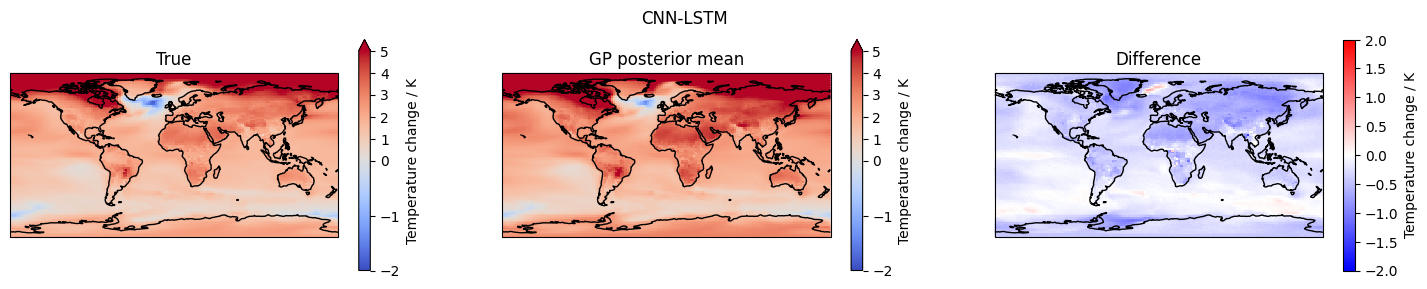

In [22]:
plot_diff(tas_truth, m_pred, 'CNN-LSTM')

In [23]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense

cnn1_model = Sequential()
cnn1_model.add(ConvLSTM2D(32, (3, 3), activation='relu', input_shape=(10, 96, 144, 4)))
cnn1_model.add(Flatten())
cnn1_model.add(Dense(256, activation='relu'))
cnn1_model.add(Dense(1*96*144, activation='linear'))
cnn1_model.add(Reshape((1, 96, 144)))

cnn1_model.summary()

/Users/nightfury/UCSD/SPRING 2024/SIOC 209/sioc209-2024-sp/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 94, 142, 32)    │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 427136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │   109,347,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13824)          │     3,552,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 96, 144)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,941,440 (430.84 MB)

 Trainable params: 112,941,440 (430.84 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cnn1_model.compile(optimizer='adam', loss='mse', metrics=['mse']) 

In [25]:
hist = cnn1_model.fit(X_train_all,
                     Y_train_all,
                     #use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=20,
                     verbose=1)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - loss: 4.8650 - mse: 4.8650
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.7320 - mse: 0.7320
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.5703 - mse: 0.5703
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.5851 - mse: 0.5851
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.5277 - mse: 0.5277
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.6055 - mse: 0.6055
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.6108 - mse: 0.6108
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.8121 - mse: 0.8121
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.7652 - mse: 0.7652
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.5414 - mse: 0.5414
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.5240 - mse: 0.5240
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.5210 - mse: 0.5210
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/ste

In [26]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = sliding_window_X(X_test.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical)  

In [27]:
# Make predictions using trained model 
m_pred = cnn1_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], 
                      coords=[X_test.time.data[len_historical:], 
                              X_test.latitude.data, 
                              X_test.longitude.data]).sel(time=slice(2015, 2101))
m_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


<xarray.DataArray (time: 86, lat: 96, lon: 144)> Size: 5MB
array([[[0.91675216, 0.9388579 , 0.82472765, ..., 0.9408269 ,
         0.96551484, 0.8580585 ],
        [1.0350298 , 0.84880066, 0.8919557 , ..., 1.0149254 ,
         0.92573464, 0.91621065],
        [0.86468065, 0.97349435, 1.0181173 , ..., 0.83229595,
         0.93500584, 0.9763175 ],
        ...,
        [2.7423346 , 2.702444  , 2.5965965 , ..., 2.6181555 ,
         2.6317708 , 2.6450238 ],
        [2.8587525 , 2.856754  , 2.8730276 , ..., 2.847882  ,
         2.7855902 , 2.9555159 ],
        [2.8854182 , 2.9088488 , 2.991354  , ..., 2.9926941 ,
         2.8968532 , 2.8752446 ]],

       [[0.9516466 , 0.9863769 , 0.8898293 , ..., 0.98449075,
         1.0054245 , 0.90414125],
        [1.0708344 , 0.91550326, 0.9454964 , ..., 1.0502124 ,
         0.9876696 , 0.96279186],
        [0.9183458 , 1.0145164 , 1.0559967 , ..., 0.8866515 ,
         0.9938896 , 1.0147219 ],
...
        [6.9859514 , 7.071201  , 7.063733  , ..., 7.14778   ,
         7.1566625 , 7.0612316 ],
        [7.2219396 , 7.192886  , 7.09605   , ..., 7.156948  ,
         7.2427483 , 7.293234  ],
        [7.375238  , 7.3255925 , 7.335896  , ..., 7.28663   ,
         7.291513  , 7.233778  ]],

       [[2.8873417 , 2.8989973 , 2.8372662 , ..., 2.856568  ,
         2.912209  , 2.8943827 ],
        [3.2013514 , 3.1097162 , 3.1819122 , ..., 3.1157868 ,
         3.213647  , 3.0798492 ],
        [3.1007333 , 3.211016  , 3.2188666 , ..., 2.9002922 ,
         3.1698048 , 3.1314437 ],
        ...,
        [7.011045  , 7.096981  , 7.089378  , ..., 7.173462  ,
         7.1824393 , 7.0876474 ],
        [7.247942  , 7.2190223 , 7.1212153 , ..., 7.1826024 ,
         7.2689285 , 7.319862  ],
        [7.401515  , 7.351649  , 7.3618917 , ..., 7.31193   ,
         7.3167    , 7.2588077 ]]], dtype=float32)
Coordinates:
  * time     (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [28]:
tas_truth = xr.open_mfdataset([data_path + 'outputs_ssp245.nc'])['tas'].mean('member').compute()
# Compute RMSEs
print(f"RMSE 2090-2100: {get_rmse(tas_truth[65:], m_pred[65:].data).mean()}")


RMSE 2090-2100: 0.5184887037409419


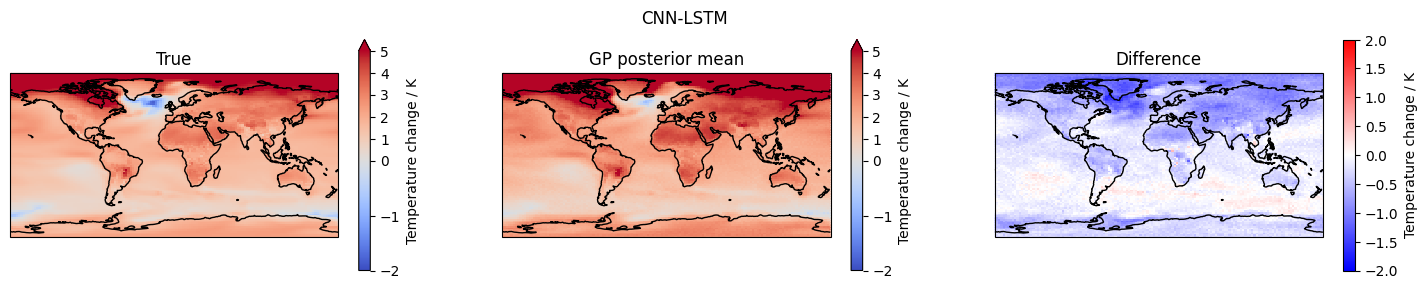

In [29]:
plot_diff(tas_truth, m_pred, 'CNN-LSTM')